In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Read the Parquet file
df = spark.read.parquet("working_data/Filtered_Fish_Data.parquet")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/13 10:48:23 WARN Utils: Your hostname, codespaces-6557a2, resolves to a loopback address: 127.0.0.1; using 10.0.0.200 instead (on interface eth0)
25/07/13 10:48:23 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/13 10:48:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df.show(5)

+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+--------------------+-----------------+----------------------+---------------------+-----------+--------+
|   111032|           1989|       196|        Rudd|Scardinius erythr...|     SE5530009200|                409200|               455300|        142|     >4+|
|    72230|           2002|       196|        Rudd|Scardinius erythr...|     SE7920071500|                471500|               479200|         29|      0+|
|    51949|           2001|       196|        Rudd|Scardinius erythr...|     SU5880008700|                108700|               458800|        157|      0+|
|    67760|           2001|       196|        Rudd|Scardin

In [3]:
df.printSchema()

root
 |-- SURVEY_ID: integer (nullable = true)
 |-- EVENT_DATE_YEAR: long (nullable = true)
 |-- SPECIES_ID: integer (nullable = true)
 |-- SPECIES_NAME: string (nullable = true)
 |-- LATIN_NAME: string (nullable = true)
 |-- SURVEY_RANKED_NGR: string (nullable = true)
 |-- SURVEY_RANKED_NORTHING: long (nullable = true)
 |-- SURVEY_RANKED_EASTING: long (nullable = true)
 |-- FISH_LENGTH: integer (nullable = true)
 |-- AGE_BAND: string (nullable = true)



In [2]:
from pyspark.sql.functions import col

filtered_df = df.filter(
    (col("SURVEY_RANKED_NORTHING") >= 375000) &
    (col("SURVEY_RANKED_NORTHING") <= 400000) &
    (col("SURVEY_RANKED_EASTING") > 620000)
)

filtered_df.show()
filtered_df.count()


+---------+---------------+----------+------------+-----------+-----------------+----------------------+---------------------+-----------+--------+
|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME| LATIN_NAME|SURVEY_RANKED_NGR|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|FISH_LENGTH|AGE_BAND|
+---------+---------------+----------+------------+-----------+-----------------+----------------------+---------------------+-----------+--------+
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|        117|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|        130|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|               648800|         90|    NULL|
|    17078|           1987|       193|     Gudgeon|Gobio gobio|     TG4880092400|                392400|        

219

In [3]:
# Using left_anti join to remove rows in df that are present in filtered_df
df = df.join(
    filtered_df,
    on=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING"],
    how="left_anti"
)

In [4]:
from pyspark.sql.functions import col

summary_data = []
for c in df.columns:
    total = df.select(c).count()
    uniques = df.select(c).distinct().count()
    summary_data.append((c, total, uniques))

# Print header
print(f"{'Column':<25} | {'Count of values':<15} | {'Unique Entries':<10}")
print("-" * 60)

# Print each line aligned
for col_name, total, uniques in summary_data:
    print(f"{col_name:<25} | {total:<15} | {uniques:<10}")

# Count of all SPECIES_ID
species_counts_pre = df.groupBy("SPECIES_NAME").count().orderBy("SPECIES_NAME")
species_counts_pre.show()

Column                    | Count of values | Unique Entries
------------------------------------------------------------
SURVEY_RANKED_NORTHING    | 4915259         | 9179      
SURVEY_RANKED_EASTING     | 4915259         | 9036      
SURVEY_ID                 | 4915259         | 30538     
EVENT_DATE_YEAR           | 4915259         | 49        
SPECIES_ID                | 4915259         | 13        
SPECIES_NAME              | 4915259         | 13        
LATIN_NAME                | 4915259         | 12        
SURVEY_RANKED_NGR         | 4915259         | 11873     
FISH_LENGTH               | 4915259         | 1019      
AGE_BAND                  | 4915259         | 63        


+--------------+-------+
|  SPECIES_NAME|  count|
+--------------+-------+
|        Barbel|  18114|
|         Bleak| 191489|
|          Chub| 313478|
|  Common bream| 221724|
|          Dace| 447320|
|      Grayling|  41497|
|       Gudgeon| 365137|
|         Perch| 403472|
|          Pike| 109604|
|Pike varieties|   3082|
|         Roach|2666111|
|          Rudd|  38638|
|  Silver bream|  95593|
+--------------+-------+



In [ ]:
    from pyspark.sql.functions import when
    from pyspark.sql.functions import first

    df = df.withColumn(
        "SPECIES_ID",
        when(col("SPECIES_ID") == 212, 213).otherwise(col("SPECIES_ID"))
    ).withColumn(
        "SPECIES_NAME",
        when(col("SPECIES_NAME") == "Pike varieties", "Pike").otherwise(col("SPECIES_NAME"))
    )

    species_counts_post = df.groupBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME") \
        .count() \
        .orderBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME")
    species_counts_post.show()

+----------+------------+--------------------+-------+
|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|  count|
+----------+------------+--------------------+-------+
|       151|      Barbel|       Barbus barbus|  18114|
|       152|        Chub|  Leuciscus cephalus| 313478|
|       153|        Dace| Leuciscus leuciscus| 447320|
|       154|    Grayling| Thymallus thymallus|  41497|
|       181|       Bleak|   Alburnus alburnus| 191489|
|       182|Common bream|       Abramis brama| 221724|
|       193|     Gudgeon|         Gobio gobio| 365137|
|       194|       Roach|     Rutilus rutilus|2666111|
|       196|        Rudd|Scardinius erythr...|  38638|
|       199|Silver bream|    Abramis bjoerkna|  95593|
|       211|       Perch|   Perca fluviatilis| 403472|
|       213|        Pike|         Esox lucius| 112686|
+----------+------------+--------------------+-------+



In [6]:
# Simple dictionary with species and their max lengths as depicted via fishbase.se, all values collected on 11/07/2025.
species_max_dict = {
    "Barbel": 1200,
    "Chub": 600,
    "Dace": 400,
    "Grayling": 600,
    "Bleak": 250,
    "Common bream": 820,
    "Gudgeon": 210,
    "Roach": 502,
    "Rudd": 617,
    "Silver bream": 455,
    "Perch": 600,
    "Pike": 1370
}

# Convert the dict to a list of dicts for filtering
species_max_list = [
    {"SPECIES_NAME": k, "MAX_LENGTH": v} for k, v in species_max_dict.items()
]

# Filter expression for all species
from pyspark.sql.functions import col
from functools import reduce

filters = [
    (col("SPECIES_NAME") == row["SPECIES_NAME"]) & (col("FISH_LENGTH") <= row["MAX_LENGTH"])
    for row in species_max_list
]
combined_filter = reduce(lambda a, b: a | b, filters)

df = df.filter(combined_filter)

df.show(10)
print("Filtered count:", df.count())

+----------------------+---------------------+---------+---------------+----------+------------+--------------------+-----------------+-----------+--------+
|SURVEY_RANKED_NORTHING|SURVEY_RANKED_EASTING|SURVEY_ID|EVENT_DATE_YEAR|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|SURVEY_RANKED_NGR|FISH_LENGTH|AGE_BAND|
+----------------------+---------------------+---------+---------------+----------+------------+--------------------+-----------------+-----------+--------+
|                409200|               455300|   111032|           1989|       196|        Rudd|Scardinius erythr...|     SE5530009200|        142|     >4+|
|                471500|               479200|    72230|           2002|       196|        Rudd|Scardinius erythr...|     SE7920071500|         29|      0+|
|                108700|               458800|    51949|           2001|       196|        Rudd|Scardinius erythr...|     SU5880008700|        157|      0+|
|                454200|               509100|    67760|  

Filtered count: 4915168


In [7]:
from pyspark.sql.functions import col

# Count of each species in df (after all filtering)
species_counts = df.groupBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME").count().orderBy("SPECIES_ID", "SPECIES_NAME", "LATIN_NAME")

# Join with species_counts_post to get count before and after filtering
species_counts_with_post = species_counts.join(
    species_counts_post.select("SPECIES_ID", "count").withColumnRenamed("count", "count_post_filter"),
    on="SPECIES_ID",
    how="left"
)

# Calculate difference
species_counts_with_post = species_counts_with_post.withColumn(
    "count_removed", col("count_post_filter") - col("count")
)

species_counts_with_post.show()


+----------+------------+--------------------+-------+-----------------+-------------+
|SPECIES_ID|SPECIES_NAME|          LATIN_NAME|  count|count_post_filter|count_removed|
+----------+------------+--------------------+-------+-----------------+-------------+
|       151|      Barbel|       Barbus barbus|  18114|            18114|            0|
|       182|Common bream|       Abramis brama| 221724|           221724|            0|
|       211|       Perch|   Perca fluviatilis| 403455|           403472|           17|
|       194|       Roach|     Rutilus rutilus|2666104|          2666111|            7|
|       193|     Gudgeon|         Gobio gobio| 365097|           365137|           40|
|       153|        Dace| Leuciscus leuciscus| 447310|           447320|           10|
|       199|Silver bream|    Abramis bjoerkna|  95590|            95593|            3|
|       152|        Chub|  Leuciscus cephalus| 313467|           313478|           11|
|       154|    Grayling| Thymallus thymall

In [8]:
from pyspark.sql.functions import col, avg

# North/South split
northing_median = df.approxQuantile("SURVEY_RANKED_NORTHING", [0.5], 0.01)[0]
df_ns = df.withColumn("region_ns", (col("SURVEY_RANKED_NORTHING") > northing_median).cast("string"))

# East/West split
easting_median = df.approxQuantile("SURVEY_RANKED_EASTING", [0.5], 0.01)[0]
df_ew = df.withColumn("region_ew", (col("SURVEY_RANKED_EASTING") > easting_median).cast("string"))

# Quadrant split (both northing and easting)
df_quad = df.withColumn(
    "quadrant",
    (col("SURVEY_RANKED_NORTHING") > northing_median).cast("int") * 2 +
    (col("SURVEY_RANKED_EASTING") > easting_median).cast("int")
)

# Show mean fish length for each split
print("North/South split:")
df_ns.groupBy("region_ns").agg(avg("FISH_LENGTH").alias("mean_length")).show()

print("East/West split:")
df_ew.groupBy("region_ew").agg(avg("FISH_LENGTH").alias("mean_length")).show()

print("Quadrant split (0=SW, 1=SE, 2=NW, 3=NE):")
df_quad.groupBy("quadrant").agg(avg("FISH_LENGTH").alias("mean_length")).show()

North/South split:


+---------+------------------+
|region_ns|       mean_length|
+---------+------------------+
|    false|129.34743529659804|
|     true|115.79517864791583|
+---------+------------------+

East/West split:


+---------+------------------+
|region_ew|       mean_length|
+---------+------------------+
|    false|125.91756825789096|
|     true|119.19282256472054|
+---------+------------------+

Quadrant split (0=SW, 1=SE, 2=NW, 3=NE):


+--------+------------------+
|quadrant|       mean_length|
+--------+------------------+
|       1|128.66221743775645|
|       3|109.71584532323031|
|       2|121.86239855039608|
|       0| 130.0438345217352|
+--------+------------------+



In [9]:
from pyspark.sql.functions import col, avg, when

# Calculate medians for splitting
northing_median = df.approxQuantile("SURVEY_RANKED_NORTHING", [0.5], 0.01)[0]
easting_median = df.approxQuantile("SURVEY_RANKED_EASTING", [0.5], 0.01)[0]

# Add region columns with descriptive names
df_ns = df.withColumn(
    "region_ns",
    when(col("SURVEY_RANKED_NORTHING") > northing_median, "North").otherwise("South")
)
df_ew = df.withColumn(
    "region_ew",
    when(col("SURVEY_RANKED_EASTING") > easting_median, "East").otherwise("West")
)
df_quad = df.withColumn(
    "quadrant",
    when(
        (col("SURVEY_RANKED_NORTHING") > northing_median) & (col("SURVEY_RANKED_EASTING") > easting_median), "NE"
    ).when(
        (col("SURVEY_RANKED_NORTHING") > northing_median) & (col("SURVEY_RANKED_EASTING") <= easting_median), "NW"
    ).when(
        (col("SURVEY_RANKED_NORTHING") <= northing_median) & (col("SURVEY_RANKED_EASTING") > easting_median), "SE"
    ).otherwise("SW")
)

# Mean fish length by species and region
print("North/South split by species:")
df_ns.groupBy("SPECIES_NAME", "region_ns").agg(avg("FISH_LENGTH").alias("mean_length")).show()

print("East/West split by species:")
df_ew.groupBy("SPECIES_NAME", "region_ew").agg(avg("FISH_LENGTH").alias("mean_length")).show()

print("Quadrant split by species (NE, NW, SE, SW):")
df_quad.groupBy("SPECIES_NAME", "quadrant").agg(avg("FISH_LENGTH").alias("mean_length")).show()

North/South split by species:


+------------+---------+------------------+
|SPECIES_NAME|region_ns|       mean_length|
+------------+---------+------------------+
|Silver bream|    North| 98.58151687833798|
|       Perch|    South| 119.4007656520918|
|      Barbel|    North|254.48272703480765|
|        Dace|    South|130.11379684178993|
|Common bream|    North|146.52726202478536|
|    Grayling|    North| 181.8151964447241|
|        Pike|    North|363.20480805538074|
|      Barbel|    South|314.72173414820475|
|Common bream|    South| 156.0537617074783|
|       Roach|    North|104.86865778485338|
|        Chub|    North|191.83004559499585|
|     Gudgeon|    North| 89.29569122575518|
|        Dace|    North|122.19954702872413|
|        Rudd|    North|107.86137963739831|
|Silver bream|    South| 93.65521819441237|
|       Bleak|    North| 91.65915397487767|
|    Grayling|    South|186.65955196017424|
|       Bleak|    South| 85.72938355119977|
|     Gudgeon|    South| 94.64616905031116|
|        Pike|    South|372.6756

+------------+---------+------------------+
|SPECIES_NAME|region_ew|       mean_length|
+------------+---------+------------------+
|     Gudgeon|     West| 90.63326675252087|
|        Chub|     East|215.26045549070233|
|Common bream|     West|171.12873937231026|
|        Rudd|     East|107.14617849327915|
|        Dace|     West|122.29367873511268|
|        Pike|     East| 341.1117302966322|
|        Chub|     West|195.66948384020642|
|        Rudd|     West|106.71378200214625|
|       Roach|     West|109.50298684545459|
|Silver bream|     East| 97.91576161950681|
|       Roach|     East|106.75069749049389|
|    Grayling|     East| 164.9067739771965|
|        Dace|     East|133.45382967162527|
|      Barbel|     East|284.33426475724764|
|      Barbel|     West| 290.2415579306275|
|       Bleak|     East| 96.26083981167196|
|     Gudgeon|     East| 96.12625454120158|
|Common bream|     East|137.70253181955633|
|       Bleak|     West| 85.05307992643026|
|    Grayling|     West|184.3912

+------------+--------+------------------+
|SPECIES_NAME|quadrant|       mean_length|
+------------+--------+------------------+
|     Gudgeon|      NE| 88.86575972791837|
|      Barbel|      SW| 322.1255877258104|
|       Roach|      SE|111.40769343108333|
|       Roach|      NE|102.87345841505066|
|Common bream|      NW|177.29150857802705|
|        Dace|      SE|135.05252812427733|
|Common bream|      SE| 152.5854340920351|
|Common bream|      SW|160.34700577200576|
|        Pike|      SE| 338.2156051426038|
|        Dace|      NE|128.56265606792076|
|       Bleak|      NW| 85.15586860161515|
|       Roach|      NW|107.49511026316547|
|        Rudd|      SW|103.73319179051663|
|      Barbel|      SE| 289.6849372384937|
|Common bream|      NE|133.10990602095418|
|     Gudgeon|      SE| 98.16487847807362|
|Silver bream|      NE|100.26209644294751|
|    Grayling|      SE| 157.1765601217656|
|        Chub|      SE| 210.2464320880066|
|       Perch|      NE| 87.09939699751284|
+----------

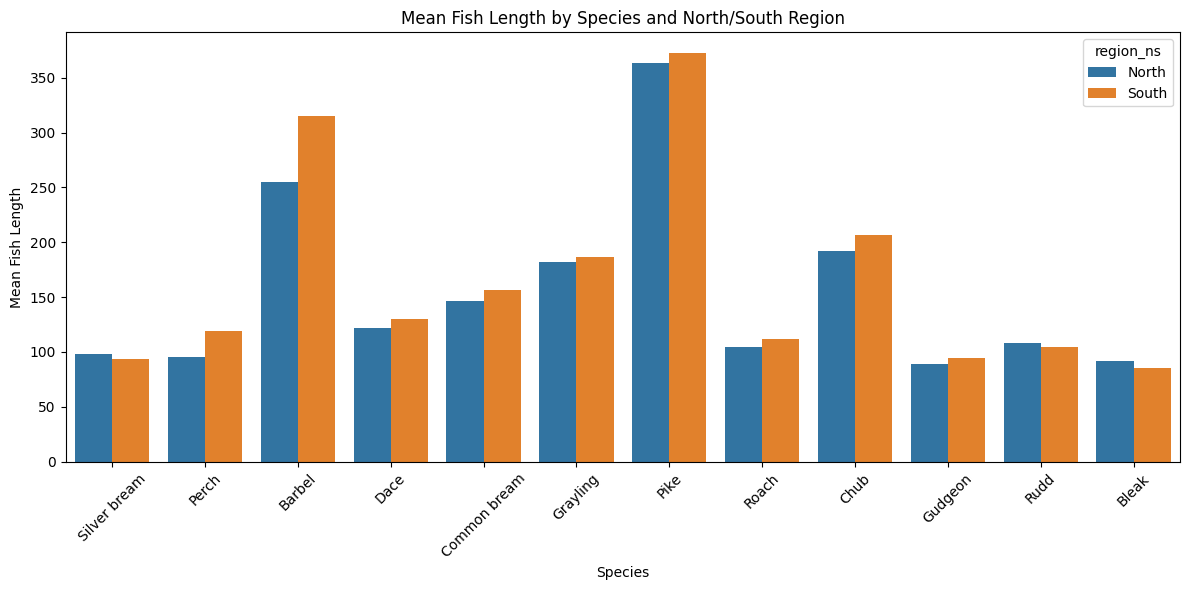

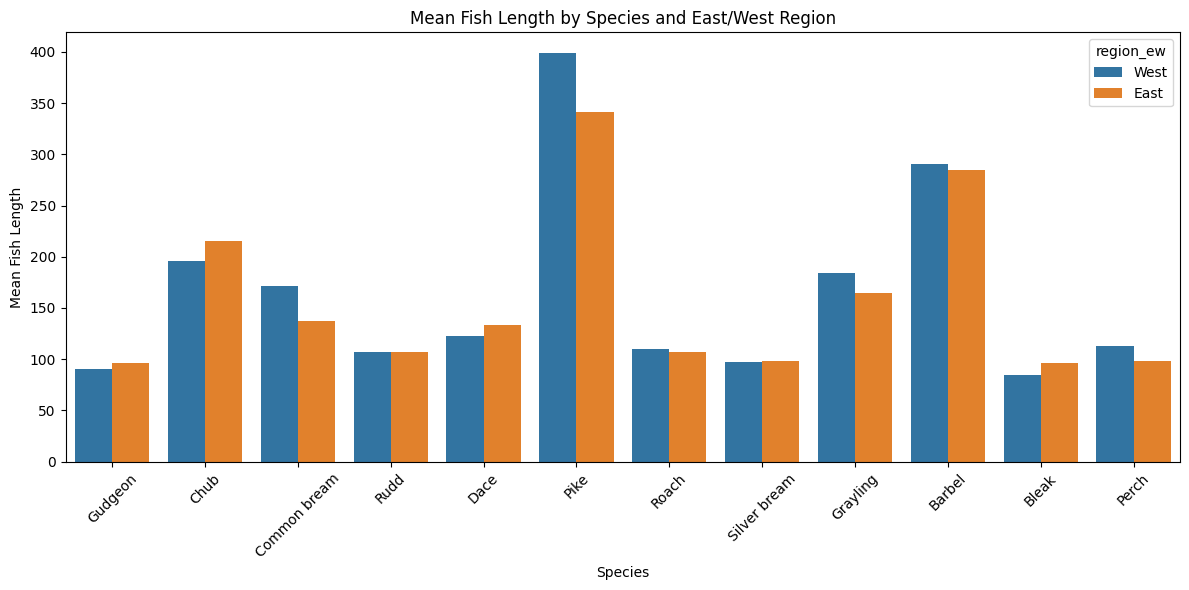

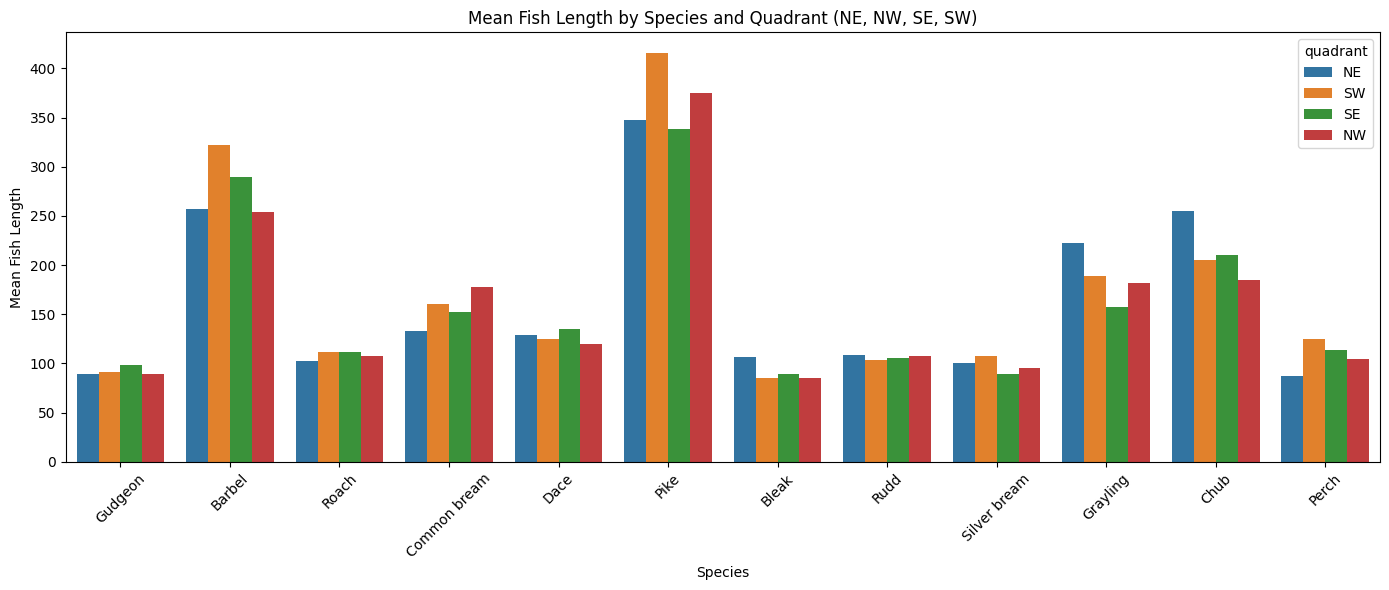

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. North/South split by species (with region names)
pdf_ns = df_ns.groupBy("SPECIES_NAME", "region_ns").agg(avg("FISH_LENGTH").alias("mean_length")).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_ns, x="SPECIES_NAME", y="mean_length", hue="region_ns")
plt.title("Mean Fish Length by Species and North/South Region")
plt.ylabel("Mean Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. East/West split by species (with region names)
pdf_ew = df_ew.groupBy("SPECIES_NAME", "region_ew").agg(avg("FISH_LENGTH").alias("mean_length")).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_ew, x="SPECIES_NAME", y="mean_length", hue="region_ew")
plt.title("Mean Fish Length by Species and East/West Region")
plt.ylabel("Mean Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Quadrant split by species (with quadrant names)
pdf_quad = df_quad.groupBy("SPECIES_NAME", "quadrant").agg(avg("FISH_LENGTH").alias("mean_length")).toPandas()
plt.figure(figsize=(14, 6))
sns.barplot(data=pdf_quad, x="SPECIES_NAME", y="mean_length", hue="quadrant")
plt.title("Mean Fish Length by Species and Quadrant (NE, NW, SE, SW)")
plt.ylabel("Mean Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
from pyspark.sql.functions import col, expr, when

# Calculate medians for splitting
northing_median = df.approxQuantile("SURVEY_RANKED_NORTHING", [0.5], 0.01)[0]
easting_median = df.approxQuantile("SURVEY_RANKED_EASTING", [0.5], 0.01)[0]

# Add region columns with descriptive names
df_ns = df.withColumn(
    "region_ns",
    when(col("SURVEY_RANKED_NORTHING") > northing_median, "North").otherwise("South")
)
df_ew = df.withColumn(
    "region_ew",
    when(col("SURVEY_RANKED_EASTING") > easting_median, "East").otherwise("West")
)
df_quad = df.withColumn(
    "quadrant",
    when(
        (col("SURVEY_RANKED_NORTHING") > northing_median) & (col("SURVEY_RANKED_EASTING") > easting_median), "NE"
    ).when(
        (col("SURVEY_RANKED_NORTHING") > northing_median) & (col("SURVEY_RANKED_EASTING") <= easting_median), "NW"
    ).when(
        (col("SURVEY_RANKED_NORTHING") <= northing_median) & (col("SURVEY_RANKED_EASTING") > easting_median), "SE"
    ).otherwise("SW")
)

# Median fish length by species and region
print("North/South split by species (median):")
df_ns.groupBy("SPECIES_NAME", "region_ns").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).show()

print("East/West split by species (median):")
df_ew.groupBy("SPECIES_NAME", "region_ew").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).show()

print("Quadrant split by species (NE, NW, SE, SW, median):")
df_quad.groupBy("SPECIES_NAME", "quadrant").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).show()

North/South split by species (median):


+------------+---------+-------------+
|SPECIES_NAME|region_ns|median_length|
+------------+---------+-------------+
|Silver bream|    North|           91|
|       Perch|    South|          105|
|      Barbel|    North|          192|
|        Dace|    South|          129|
|Common bream|    North|          100|
|    Grayling|    North|          188|
|        Pike|    North|          322|
|      Barbel|    South|          264|
|Common bream|    South|          100|
|       Roach|    North|           98|
|        Chub|    North|          167|
|     Gudgeon|    North|           91|
|        Dace|    North|          117|
|        Rudd|    North|          100|
|Silver bream|    South|           86|
|       Bleak|    North|           95|
|    Grayling|    South|          187|
|       Bleak|    South|           88|
|     Gudgeon|    South|           97|
|        Pike|    South|          338|
+------------+---------+-------------+
only showing top 20 rows
East/West split by species (median):


+------------+---------+-------------+
|SPECIES_NAME|region_ew|median_length|
+------------+---------+-------------+
|     Gudgeon|     West|           94|
|        Chub|     East|          192|
|Common bream|     West|          120|
|        Rudd|     East|           98|
|        Dace|     West|          119|
|        Pike|     East|          294|
|        Chub|     West|          168|
|        Rudd|     West|          100|
|       Roach|     West|          103|
|Silver bream|     East|           90|
|       Roach|     East|           98|
|    Grayling|     East|          134|
|        Dace|     East|          132|
|      Barbel|     East|          229|
|      Barbel|     West|          230|
|       Bleak|     East|           98|
|     Gudgeon|     East|           96|
|Common bream|     East|           93|
|       Bleak|     West|           88|
|    Grayling|     West|          189|
+------------+---------+-------------+
only showing top 20 rows
Quadrant split by species (NE, NW, SE, 

+------------+--------+-------------+
|SPECIES_NAME|quadrant|median_length|
+------------+--------+-------------+
|     Gudgeon|      NE|           88|
|      Barbel|      SW|          282|
|       Roach|      SE|          103|
|       Roach|      NE|           95|
|Common bream|      NW|          132|
|        Dace|      SE|          134|
|Common bream|      SE|           98|
|Common bream|      SW|          103|
|        Pike|      SE|          292|
|        Dace|      NE|          125|
|       Bleak|      NW|           90|
|       Roach|      NW|          101|
|        Rudd|      SW|           98|
|      Barbel|      SE|          242|
|Common bream|      NE|           91|
|     Gudgeon|      SE|           98|
|Silver bream|      NE|           92|
|    Grayling|      SE|          130|
|        Chub|      SE|          188|
|       Perch|      NE|           77|
+------------+--------+-------------+
only showing top 20 rows


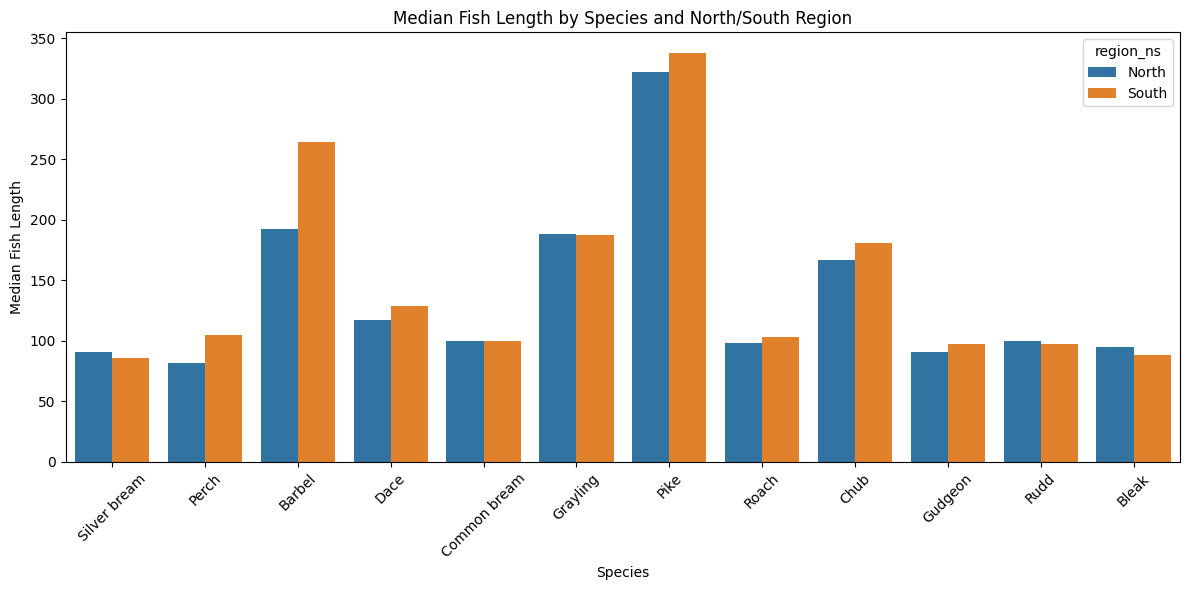

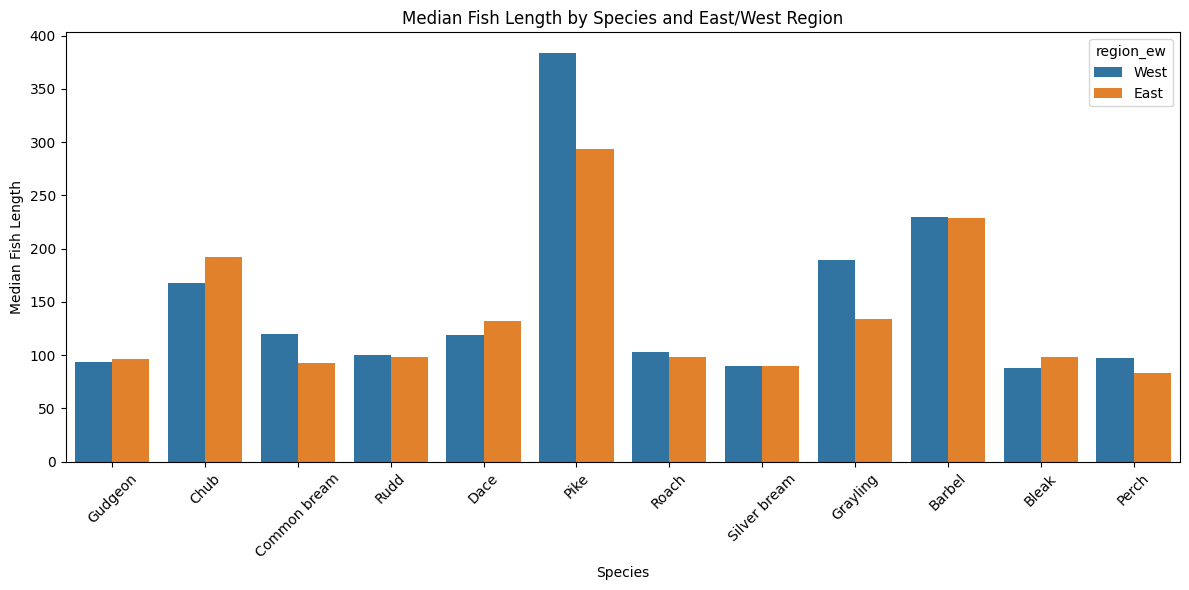

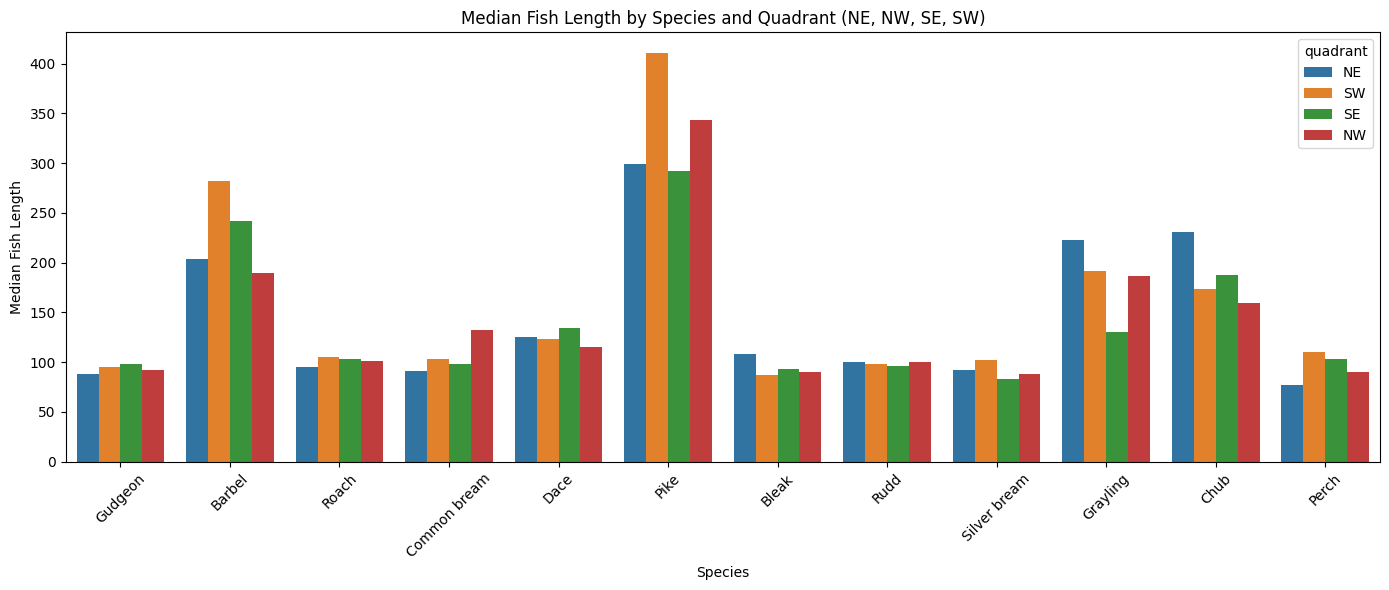

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import expr

# 1. North/South split by species (median)
pdf_ns = df_ns.groupBy("SPECIES_NAME", "region_ns").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_ns, x="SPECIES_NAME", y="median_length", hue="region_ns")
plt.title("Median Fish Length by Species and North/South Region")
plt.ylabel("Median Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. East/West split by species (median)
pdf_ew = df_ew.groupBy("SPECIES_NAME", "region_ew").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=pdf_ew, x="SPECIES_NAME", y="median_length", hue="region_ew")
plt.title("Median Fish Length by Species and East/West Region")
plt.ylabel("Median Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Quadrant split by species (median)
pdf_quad = df_quad.groupBy("SPECIES_NAME", "quadrant").agg(expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length")).toPandas()
plt.figure(figsize=(14, 6))
sns.barplot(data=pdf_quad, x="SPECIES_NAME", y="median_length", hue="quadrant")
plt.title("Median Fish Length by Species and Quadrant (NE, NW, SE, SW)")
plt.ylabel("Median Fish Length")
plt.xlabel("Species")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [13]:
from pyspark.sql.functions import when, col, avg, count, expr

# Use the actual centre of England (British National Grid)
centre_easting = 438000
centre_northing = 350000

# Add region columns
df_ns = df.withColumn("region_ns", when(col("SURVEY_RANKED_NORTHING") > centre_northing, "North").otherwise("South"))
df_ew = df.withColumn("region_ew", when(col("SURVEY_RANKED_EASTING") > centre_easting, "East").otherwise("West"))

# Aggregate in Spark: mean, median, and count by species and region
agg_ns = df_ns.groupBy("SPECIES_NAME", "region_ns").agg(
    avg("FISH_LENGTH").alias("mean_length"),
    expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length"),
    count("FISH_LENGTH").alias("count")
).orderBy("SPECIES_NAME", "region_ns")

agg_ew = df_ew.groupBy("SPECIES_NAME", "region_ew").agg(
    avg("FISH_LENGTH").alias("mean_length"),
    expr("percentile_approx(FISH_LENGTH, 0.5)").alias("median_length"),
    count("FISH_LENGTH").alias("count")
).orderBy("SPECIES_NAME", "region_ew")

# Show summary statistics for each split
print("North/South split by species:")
agg_ns.show(truncate=False)

print("East/West split by species:")
agg_ew.show(truncate=False)

# Collect only the summary to pandas for further analysis or plotting
pdf_ns = agg_ns.toPandas()
pdf_ew = agg_ew.toPandas()

North/South split by species:


+------------+---------+------------------+-------------+-------+
|SPECIES_NAME|region_ns|mean_length       |median_length|count  |
+------------+---------+------------------+-------------+-------+
|Barbel      |North    |267.09036034388146|216          |5467   |
|Barbel      |South    |298.9119949395114 |235          |12647  |
|Bleak       |North    |88.0624514652389  |94           |24467  |
|Bleak       |South    |87.06368698359478 |89           |167020 |
|Chub        |North    |168.8998929521047 |134          |57918  |
|Chub        |South    |209.36762421296893|184          |255549 |
|Common bream|North    |167.11679865995   |132          |81191  |
|Common bream|South    |138.8370560651235 |89           |140533 |
|Dace        |North    |114.04570244587869|106          |83978  |
|Dace        |South    |130.192220888884  |129          |363332 |
|Grayling    |North    |178.65912569351445|184          |20908  |
|Grayling    |South    |188.80125309631356|190          |20589  |
|Gudgeon  

+------------+---------+------------------+-------------+-------+
|SPECIES_NAME|region_ew|mean_length       |median_length|count  |
+------------+---------+------------------+-------------+-------+
|Barbel      |East     |320.5123538132103 |285          |12142  |
|Barbel      |West     |225.86436704621568|127          |5972   |
|Bleak       |East     |87.75278055802342 |90           |177842 |
|Bleak       |West     |79.87328691828509 |83           |13645  |
|Chub        |East     |201.0854206136626 |174          |229605 |
|Chub        |West     |204.0949774629749 |185          |83862  |
|Common bream|East     |148.18411913507023|100          |209913 |
|Common bream|West     |167.11497756328845|120          |11811  |
|Dace        |East     |125.75252708417979|123          |366727 |
|Dace        |West     |133.5701450678183 |135          |80583  |
|Grayling    |East     |183.32291355070296|182          |13372  |
|Grayling    |West     |183.86631111111112|190          |28125  |
|Gudgeon  

In [14]:
import pandas as pd
from scipy.stats import ttest_ind

# Convert Spark DataFrames to pandas for easier manipulation
pdf_ns = agg_ns.toPandas()
pdf_ew = agg_ew.toPandas()

# Prepare results for each species
summary = []

for species in pdf_ns['SPECIES_NAME'].unique():
    # North/South
    ns_rows = pdf_ns[pdf_ns['SPECIES_NAME'] == species]
    if set(ns_rows['region_ns']) == {'North', 'South'}:
        north_mean = ns_rows[ns_rows['region_ns'] == 'North']['mean_length'].values[0]
        south_mean = ns_rows[ns_rows['region_ns'] == 'South']['mean_length'].values[0]
        north_median = ns_rows[ns_rows['region_ns'] == 'North']['median_length'].values[0]
        south_median = ns_rows[ns_rows['region_ns'] == 'South']['median_length'].values[0]
        north_count = ns_rows[ns_rows['region_ns'] == 'North']['count'].values[0]
        south_count = ns_rows[ns_rows['region_ns'] == 'South']['count'].values[0]
        # Get all fish lengths for t-test
        fish_ns = df_ns.filter(col("SPECIES_NAME") == species).select("FISH_LENGTH", "region_ns").toPandas()
        north = fish_ns[fish_ns["region_ns"] == "North"]["FISH_LENGTH"]
        south = fish_ns[fish_ns["region_ns"] == "South"]["FISH_LENGTH"]
        t_ns, p_ns = ttest_ind(north, south, nan_policy='omit', equal_var=False)
    else:
        north_mean = south_mean = north_median = south_median = north_count = south_count = t_ns = p_ns = None

    # East/West
    ew_rows = pdf_ew[pdf_ew['SPECIES_NAME'] == species]
    if set(ew_rows['region_ew']) == {'East', 'West'}:
        east_mean = ew_rows[ew_rows['region_ew'] == 'East']['mean_length'].values[0]
        west_mean = ew_rows[ew_rows['region_ew'] == 'West']['mean_length'].values[0]
        east_median = ew_rows[ew_rows['region_ew'] == 'East']['median_length'].values[0]
        west_median = ew_rows[ew_rows['region_ew'] == 'West']['median_length'].values[0]
        east_count = ew_rows[ew_rows['region_ew'] == 'East']['count'].values[0]
        west_count = ew_rows[ew_rows['region_ew'] == 'West']['count'].values[0]
        # Get all fish lengths for t-test
        fish_ew = df_ew.filter(col("SPECIES_NAME") == species).select("FISH_LENGTH", "region_ew").toPandas()
        east = fish_ew[fish_ew["region_ew"] == "East"]["FISH_LENGTH"]
        west = fish_ew[fish_ew["region_ew"] == "West"]["FISH_LENGTH"]
        t_ew, p_ew = ttest_ind(east, west, nan_policy='omit', equal_var=False)
    else:
        east_mean = west_mean = east_median = west_median = east_count = west_count = t_ew = p_ew = None

    summary.append({
        "species": species,
        "north_mean": north_mean,
        "south_mean": south_mean,
        "north_median": north_median,
        "south_median": south_median,
        "north_count": north_count,
        "south_count": south_count,
        "ns_pvalue": p_ns,
        "east_mean": east_mean,
        "west_mean": west_mean,
        "east_median": east_median,
        "west_median": west_median,
        "east_count": east_count,
        "west_count": west_count,
        "ew_pvalue": p_ew
    })

summary_df = pd.DataFrame(summary)
pd.set_option('display.float_format', '{:.2f}'.format)
print(summary_df)

# Interpretation suggestion:
print("\nInterpretation:")
print("If the p-value (ns_pvalue or ew_pvalue) is < 0.05 and the mean/median difference is substantial, splitting by that region is likely valuable for that species.")
print("If p-value is high or mean/median difference is small, splitting is likely not valuable.")

         species  north_mean  south_mean  north_median  south_median  \
0         Barbel      267.09      298.91           216           235   
1          Bleak       88.06       87.06            94            89   
2           Chub      168.90      209.37           134           184   
3   Common bream      167.12      138.84           132            89   
4           Dace      114.05      130.19           106           129   
5       Grayling      178.66      188.80           184           190   
6        Gudgeon       86.15       94.56            88            97   
7          Perch       95.73      110.35            82            93   
8           Pike      366.33      369.91           329           333   
9          Roach      105.55      108.81           100           101   
10          Rudd      110.35      104.33           101            96   
11  Silver bream      101.25       94.31            93            87   

    north_count  south_count  ns_pvalue  east_mean  west_mean  

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


# Get list of unique species
species_list = [row["SPECIES_ID"] for row in df.select("SPECIES_ID").distinct().collect()]

# Choose a species to analyze (change as needed)
species_to_plot = species_list[0]

# Filter for one species
df_species = df.filter(col("SPECIES_ID") == species_to_plot).dropna(subset=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING", "FISH_LENGTH"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING"],
    outputCol="features"
)
df_features = assembler.transform(df_species)

# Split into train/test sets
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(featuresCol="features", labelCol="FISH_LENGTH", regParam=0.1)

# Build parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.5, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr.fitIntercept, [True, False]) \
    .addGrid(lr.standardization, [True, False]) \
    .build()

# Set up cross-validation
crossval = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="FISH_LENGTH"),
    numFolds=5
)

# Fit cross-validated model
cvModel = crossval.fit(train_df)
model = cvModel.bestModel  # Use the best model found

# ...continue with predictions and evaluation...
test_predictions = model.transform(test_df)

# Evaluate model performance on test set
evaluator = RegressionEvaluator(
    labelCol="FISH_LENGTH", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(test_predictions)
r2 = evaluator.setMetricName("r2").evaluate(test_predictions)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# Calculate and print the mean absolute error (average absolute difference)
mae = evaluator.setMetricName("mae").evaluate(test_predictions)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Collect a sample of test predictions for plotting
pred_pd = test_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).sample(fraction=0.2, seed=42).toPandas()  # Adjust fraction as needed

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    pred_pd["SURVEY_RANKED_EASTING"],
    pred_pd["SURVEY_RANKED_NORTHING"],
    c=pred_pd["prediction"],
    cmap="viridis",
    s=10,
    alpha=0.7
)
plt.colorbar(sc, label="Predicted Fish Length")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(f"Predicted Fish Length by Location (Species ID: {species_to_plot})")
plt.tight_layout()
plt.show()

In [ ]:
# Get predictions for both train and test sets
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Convert to pandas for plotting
train_pd = train_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).toPandas()
test_pd = test_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot actual fish lengths (test set)
plt.scatter(
    test_pd["SURVEY_RANKED_EASTING"], test_pd["FISH_LENGTH"],
    color="black", alpha=0.5, label="Actual (Test)", s=15
)

# Plot predicted fish lengths (test set)
plt.scatter(
    test_pd["SURVEY_RANKED_EASTING"], test_pd["prediction"],
    color="red", alpha=0.5, label="Predicted (Test)", s=15
)

# Plot predicted fish lengths (train set)
plt.scatter(
    train_pd["SURVEY_RANKED_EASTING"], train_pd["prediction"],
    color="blue", alpha=0.3, label="Predicted (Train)", s=10
)

plt.xlabel("Easting")
plt.ylabel("Fish Length")
plt.title("Actual vs Predicted Fish Lengths (Train & Test Sets)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Get predictions for both train and test sets
train_predictions = model.transform(train_df)
test_predictions = model.transform(test_df)

# Convert to pandas for plotting
train_pd = train_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).toPandas()
test_pd = test_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Plot actual fish lengths (test set)
plt.scatter(
    test_pd["SURVEY_RANKED_NORTHING"], test_pd["FISH_LENGTH"],
    color="black", alpha=0.5, label="Actual (Test)", s=15
)

# Plot predicted fish lengths (test set)
plt.scatter(
    test_pd["SURVEY_RANKED_NORTHING"], test_pd["prediction"],
    color="red", alpha=0.5, label="Predicted (Test)", s=15
)

# Plot predicted fish lengths (train set)
plt.scatter(
    train_pd["SURVEY_RANKED_NORTHING"], train_pd["prediction"],
    color="blue", alpha=0.3, label="Predicted (Train)", s=10
)

plt.xlabel("NORTHING")
plt.ylabel("Fish Length")
plt.title("Actual vs Predicted Fish Lengths (Train & Test Sets)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Sort and compute rolling mean for smoother trend lines
test_sorted_e = test_pd.sort_values("SURVEY_RANKED_EASTING")
test_sorted_n = test_pd.sort_values("SURVEY_RANKED_NORTHING")

window = 200  # Adjust for smoothing

fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Easting
axes[0].plot(
    test_sorted_e["SURVEY_RANKED_EASTING"],
    test_sorted_e["FISH_LENGTH"].rolling(window, center=True).mean(),
    color="black", label="Actual (Test) Rolling Mean"
)
axes[0].plot(
    test_sorted_e["SURVEY_RANKED_EASTING"],
    test_sorted_e["prediction"].rolling(window, center=True).mean(),
    color="crimson", label="Predicted (Test) Rolling Mean"
)
axes[0].set_xlabel("Easting")
axes[0].set_ylabel("Fish Length")
axes[0].set_title("Fish Length vs Easting (Smoothed)")
axes[0].legend()

# Northing
axes[1].plot(
    test_sorted_n["SURVEY_RANKED_NORTHING"],
    test_sorted_n["FISH_LENGTH"].rolling(window, center=True).mean(),
    color="black", label="Actual (Test) Rolling Mean"
)
axes[1].plot(
    test_sorted_n["SURVEY_RANKED_NORTHING"],
    test_sorted_n["prediction"].rolling(window, center=True).mean(),
    color="crimson", label="Predicted (Test) Rolling Mean"
)
axes[1].set_xlabel("Northing")
axes[1].set_title("Fish Length vs Northing (Smoothed)")
axes[1].legend()

plt.suptitle("Smoothed Actual and Predicted Fish Lengths", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Example flow to generate an interactive map using folium

#### Initial step to transform coordinates from British National Grid coordinates (EPSG:27700), to Folium accepted coordinates of latitude/longitude (EPSG:4326)

```python
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
pred_pd["lon"], pred_pd["lat"] = transformer.transform(
    pred_pd["SURVEY_RANKED_EASTING"].values, pred_pd["SURVEY_RANKED_NORTHING"].values
)
```

#### Using folium to generate an interactive map

```python
import folium

# Center map on England
m = folium.Map(location=[54, -2], zoom_start=6)

# Add points
for _, row in pred_pd.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=3,
        color=None,
        fill=True,
        fill_color=plt.cm.viridis((row["prediction"] - pred_pd["prediction"].min()) / (pred_pd["prediction"].max() - pred_pd["prediction"].min())),
        fill_opacity=0.7,
        popup=f"Predicted Length: {row['prediction']:.1f}"
    ).add_to(m)

m.save("fish_length_map.html")
```

In [ ]:
from pyproj import Transformer

transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
pred_pd["lon"], pred_pd["lat"] = transformer.transform(
    pred_pd["SURVEY_RANKED_EASTING"].values, pred_pd["SURVEY_RANKED_NORTHING"].values
)

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# 1. Create GeoDataFrame from pred_pd DataFrame
gdf = gpd.GeoDataFrame(
    pred_pd,
    geometry=[Point(xy) for xy in zip(pred_pd["lon"], pred_pd["lat"])],
    crs="EPSG:4326"  # WGS84
)

# 2. Project to Web Mercator for contextily
gdf = gdf.to_crs(epsg=3857)

# 3. Plot with basemap and colorbar
fig, ax = plt.subplots(figsize=(10, 10))
sc = gdf.plot(
    ax=ax,
    column="prediction",
    cmap="viridis",
    markersize=10,
    alpha=0.7,
    legend=True,
    legend_kwds={'label': "Predicted Fish Length"}
)
# Use a widely supported basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title(f"Predicted Fish Length by Location (Species ID: {species_to_plot})")
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Get list of unique species
species_list = [row["SPECIES_ID"] for row in df.select("SPECIES_ID").distinct().collect()]

# Choose a species to analyze (change as needed)
species_to_plot = species_list[0]

# Filter for one species
df_species = df.filter(col("SPECIES_ID") == species_to_plot).dropna(subset=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING", "FISH_LENGTH"])

# Assemble features
assembler = VectorAssembler(
    inputCols=["SURVEY_RANKED_NORTHING", "SURVEY_RANKED_EASTING"],
    outputCol="features"
)
df_features = assembler.transform(df_species)

# Split into train/test sets
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=42)

# Fit Random Forest regression model on training data
rf = RandomForestRegressor(featuresCol="features", labelCol="FISH_LENGTH", numTrees=50, seed=42)
model = rf.fit(train_df)

# Predict on test set
test_predictions = model.transform(test_df)

# Evaluate model performance on test set
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="FISH_LENGTH", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(test_predictions)
r2 = evaluator.setMetricName("r2").evaluate(test_predictions)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")

# Collect a sample of test predictions for plotting
pred_pd = test_predictions.select(
    "SURVEY_RANKED_EASTING", "SURVEY_RANKED_NORTHING", "FISH_LENGTH", "prediction"
).sample(fraction=0.2, seed=42).toPandas()  # Adjust fraction as needed

plt.figure(figsize=(10, 8))
sc = plt.scatter(
    pred_pd["SURVEY_RANKED_EASTING"],
    pred_pd["SURVEY_RANKED_NORTHING"],
    c=pred_pd["prediction"],
    cmap="viridis",
    s=10,
    alpha=0.7
)
plt.colorbar(sc, label="Predicted Fish Length")
plt.xlabel("Easting")
plt.ylabel("Northing")
plt.title(f"Predicted Fish Length by Location (Species ID: {species_to_plot})")
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import round, col

# 1. Calculate average fish length by species and spatial bin
agg_df = df.withColumn("NORTH_BIN", round(col("SURVEY_RANKED_NORTHING")/1000)*1000) \
    .withColumn("EAST_BIN", round(col("SURVEY_RANKED_EASTING")/1000)*1000) \
    .groupBy("SPECIES_NAME", "NORTH_BIN", "EAST_BIN") \
    .agg({"FISH_LENGTH": "avg"}) \
    .withColumnRenamed("avg(FISH_LENGTH)", "AVG_LENGTH")

# 2. Convert to pandas for plotting (choose a species to plot)
species_to_plot = "Gudgeon"
agg_pd = agg_df.filter(col("SPECIES_NAME") == species_to_plot).toPandas()

# 3. Convert bins to lat/lon for geopandas plotting
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
agg_pd["lon"], agg_pd["lat"] = transformer.transform(
    agg_pd["EAST_BIN"].values, agg_pd["NORTH_BIN"].values
)

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gpd.GeoDataFrame(
    agg_pd,
    geometry=[Point(xy) for xy in zip(agg_pd["lon"], agg_pd["lat"])],
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
sc = gdf.plot(
    ax=ax,
    column="AVG_LENGTH",
    cmap="viridis",
    markersize=30,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Average Fish Length"},
    vmin=gdf["AVG_LENGTH"].min(),
    vmax=200
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title(f"Average Fish Length by Location (Species: {species_to_plot})")
plt.tight_layout()
plt.show()

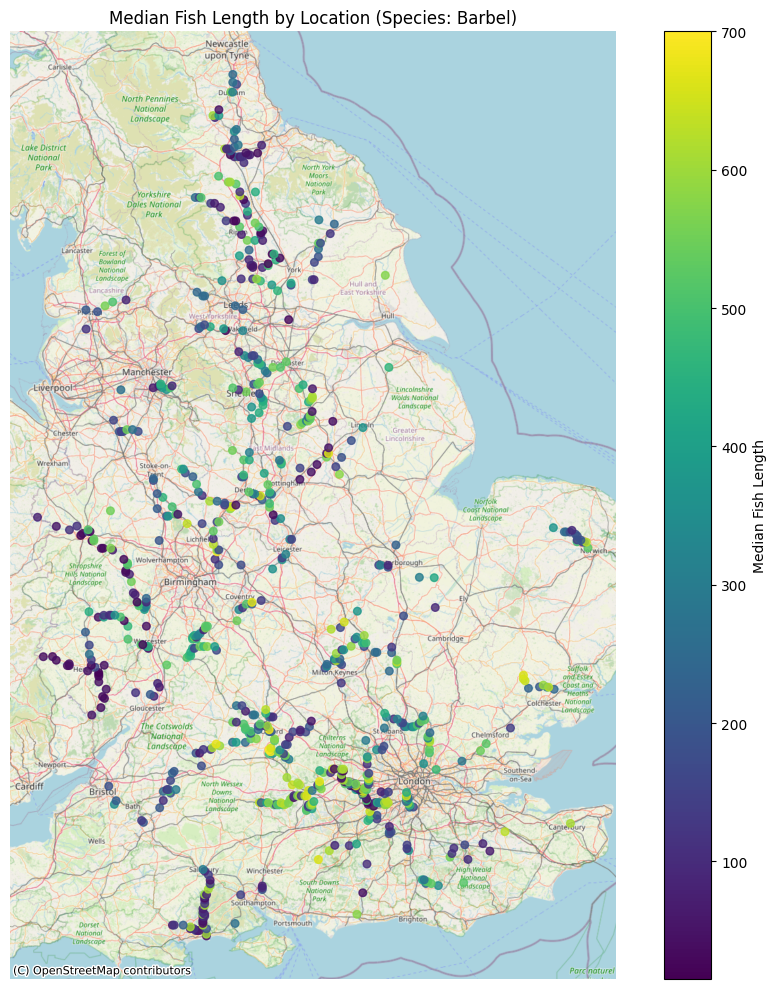

In [17]:
from pyspark.sql.functions import round, col, expr

# 1. Calculate median fish length by species and spatial bin
agg_df = df.withColumn("NORTH_BIN", round(col("SURVEY_RANKED_NORTHING")/1000)*1000) \
    .withColumn("EAST_BIN", round(col("SURVEY_RANKED_EASTING")/1000)*1000) \
    .groupBy("SPECIES_NAME", "NORTH_BIN", "EAST_BIN") \
    .agg(expr("percentile_approx(FISH_LENGTH, 0.5) as MEDIAN_LENGTH"))

# 2. Convert to pandas for plotting (choose a species to plot)
species_to_plot = "Barbel"
agg_pd = agg_df.filter(col("SPECIES_NAME") == species_to_plot).toPandas()

# 3. Convert bins to lat/lon for geopandas plotting
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
agg_pd["lon"], agg_pd["lat"] = transformer.transform(
    agg_pd["EAST_BIN"].values, agg_pd["NORTH_BIN"].values
)

import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

gdf = gpd.GeoDataFrame(
    agg_pd,
    geometry=[Point(xy) for xy in zip(agg_pd["lon"], agg_pd["lat"])],
    crs="EPSG:4326"
)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
sc = gdf.plot(
    ax=ax,
    column="MEDIAN_LENGTH",
    cmap="viridis",
    markersize=30,
    alpha=0.8,
    legend=True,
    legend_kwds={'label': "Median Fish Length"},
)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title(f"Median Fish Length by Location (Species: {species_to_plot})")
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql.functions import col, avg

# Define split (e.g., north/south at median northing)
northing_median = df.approxQuantile("SURVEY_RANKED_NORTHING", [0.5], 0.01)[0]
df = df.withColumn("region", (col("SURVEY_RANKED_NORTHING") > northing_median).cast("string"))

# Compute mean fish length per region
df.groupBy("region").agg(avg("FISH_LENGTH").alias("mean_length")).show()

# Optionally, collect to pandas and run a t-test
pdf = df.select("FISH_LENGTH", "region").toPandas()
from scipy.stats import ttest_ind
north = pdf[pdf["region"] == "1"]["FISH_LENGTH"]
south = pdf[pdf["region"] == "0"]["FISH_LENGTH"]
print(ttest_ind(north, south, nan_policy='omit'))